In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Inspect the CSV structure to determine if headers are correct
temp_df = pd.read_csv("../data/AAPL_historical.csv", nrows=5)
print("Initial CSV Columns:", temp_df.columns)

# If the CSV has extra header rows, use skiprows=2:
df = pd.read_csv("../data/AAPL_historical.csv", skiprows=2)
# Rename columns if needed:
df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

# Convert the 'Date' column to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Verify the cleaned data
print(df.head())
print(df.info())


Initial CSV Columns: Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
                Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.320429  24.789798  23.879978  24.778675  212818400
2015-01-05  23.635286  24.169166  23.448429  24.089084  257142000
2015-01-06  23.637514  23.897780  23.274920  23.699800  263188400
2015-01-07  23.968964  24.069065  23.735391  23.846616  160423600
2015-01-08  24.889904  24.947741  24.180289  24.298189  237458000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2015-01-02 to 2021-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1762 non-null   float64
 1   High    1762 non-null   float64
 2   Low     1762 non-null   float64
 3   Open    1762 non-null   float64
 4   Volume  1762 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.6 KB
None


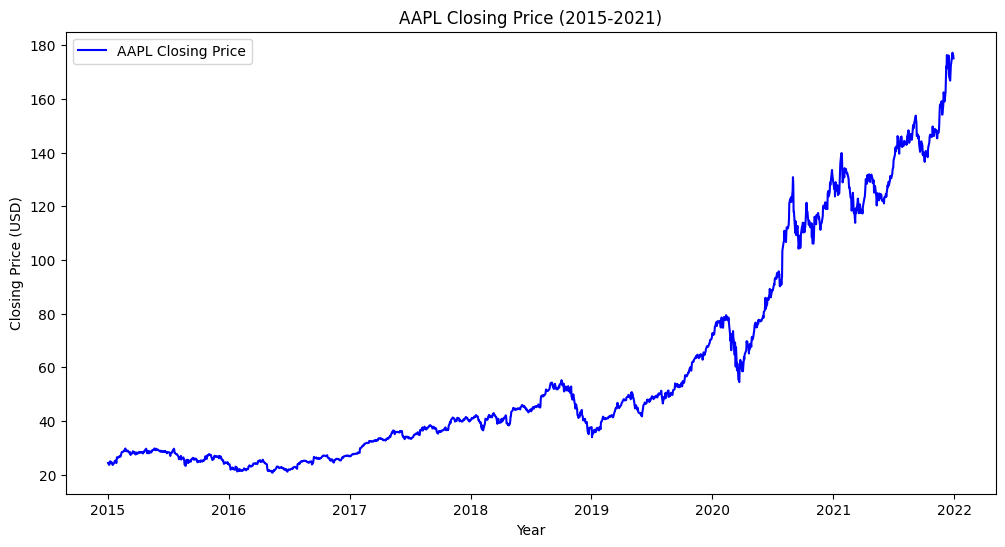

In [32]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label="AAPL Closing Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Closing Price (USD)")
plt.title("AAPL Closing Price (2015-2021)")
plt.legend()
plt.show()


In [33]:
# Determine split index (e.g., 90% training, 10% testing)
split_index = int(len(df) * 0.9)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

print("Training set size:", len(train))
print("Test set size:", len(test))


Training set size: 1585
Test set size: 177


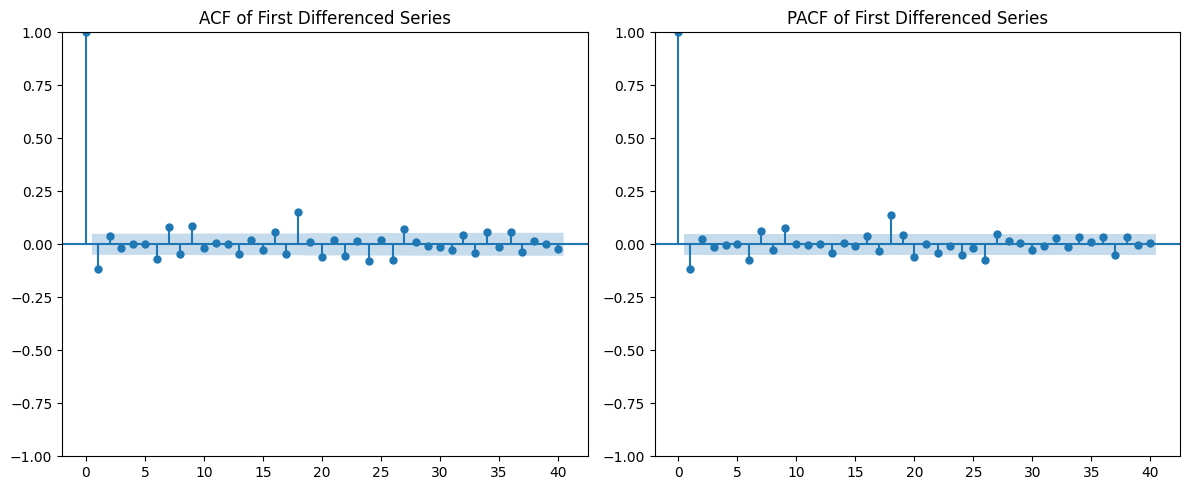

In [34]:
# Apply first differencing on training data
train_diff = train['Close'].diff().dropna()

# Plot ACF and PACF for the differenced series
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(train_diff, ax=plt.gca(), lags=40)
plt.title("ACF of First Differenced Series")
plt.subplot(1,2,2)
plot_pacf(train_diff, ax=plt.gca(), lags=40)
plt.title("PACF of First Differenced Series")
plt.tight_layout()
plt.show()


In [35]:
# Fit ARIMA model on training data
model = ARIMA(train['Close'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1585
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2604.683
Date:                Sat, 29 Mar 2025   AIC                           5215.365
Time:                        12:10:21   BIC                           5231.468
Sample:                             0   HQIC                          5221.348
                               - 1585                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3595      0.091     -3.947      0.000      -0.538      -0.181
ma.L1          0.2501      0.095      2.627      0.009       0.063       0.437
sigma2         1.5696      0.020     77.808      0.0

c:\Users\noahp\OneDrive\Documents\PortfolioProjects\Financial-Data-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\noahp\OneDrive\Documents\PortfolioProjects\Financial-Data-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\noahp\OneDrive\Documents\PortfolioProjects\Financial-Data-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\noahp\OneDrive\Documents\PortfolioProjects\Financial-Data-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\noahp\OneDrive\Documents\PortfolioProjects\Financial-Data-Analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


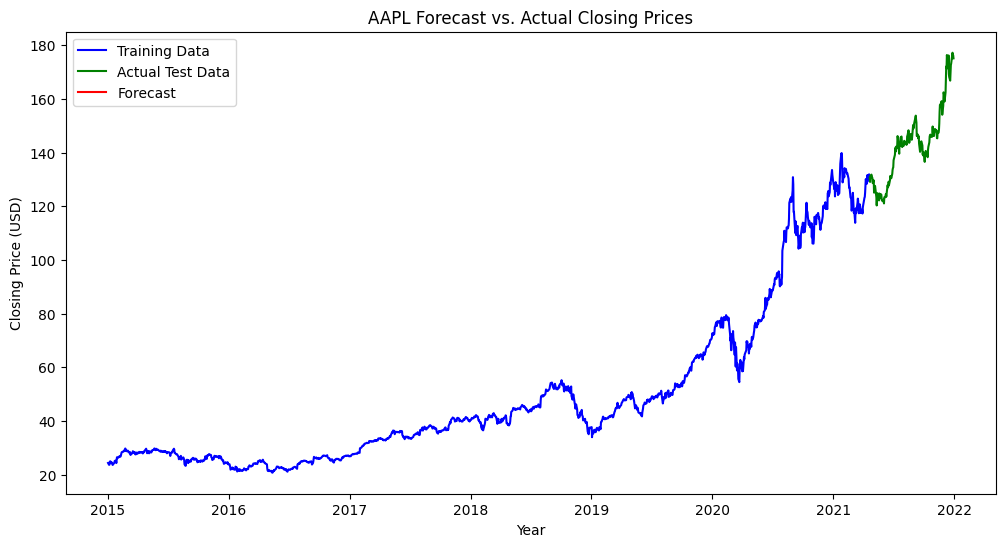

In [36]:
# Forecast the number of steps equal to the length of the test set
forecast = model_fit.forecast(steps=len(test))

# Convert forecast output to a Pandas Series with test index
forecast_series = pd.Series(forecast, index=test.index)

# Plot training, test, and forecasted values
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close'], label="Training Data", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test Data", color='green')
plt.plot(forecast_series.index, forecast_series, label="Forecast", color='red')
plt.xlabel("Year")
plt.ylabel("Closing Price (USD)")
plt.title("AAPL Forecast vs. Actual Closing Prices")
plt.legend()
plt.show()


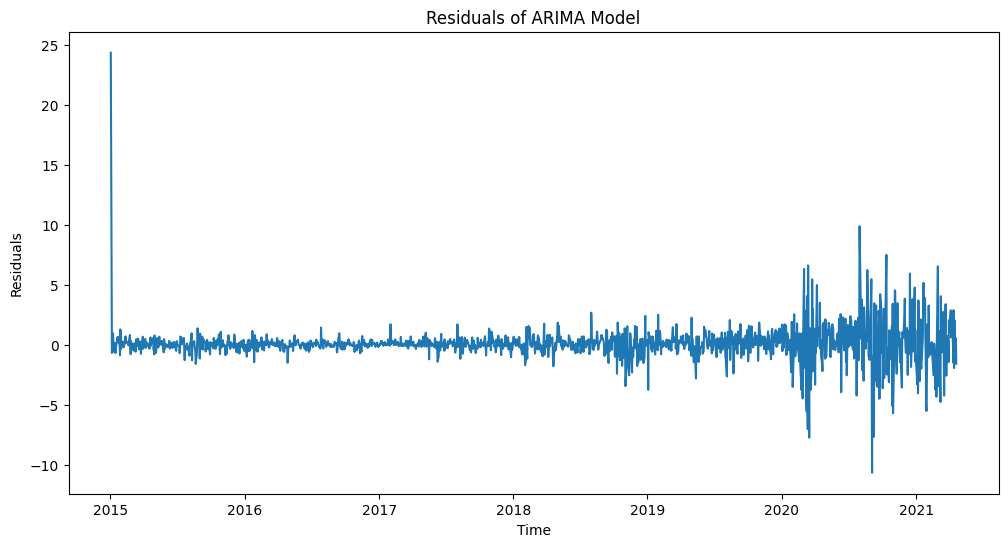

<Figure size 1000x400 with 0 Axes>

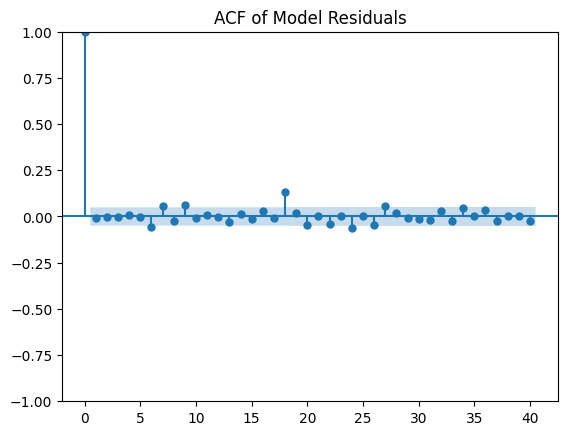

In [37]:
# Extract residuals from the fitted model
residuals = model_fit.resid

# Plot the residuals over time
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

# Plot the ACF of the residuals
plt.figure(figsize=(10,4))
plot_acf(residuals, lags=40)
plt.title("ACF of Model Residuals")
plt.show()


In [38]:
import pickle

# Save the ARIMA model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

# Save the forecasted series
forecast_series.to_pickle('forecast_series.pkl')


In [39]:
# Save the test set to a pickle file for later use in Phase 5
test.to_pickle('test_data.pkl')
# Save the training set to a pickle file for later use in Phase 5
train.to_pickle('train_data.pkl')
